In [1]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

c:\Users\Dell\anaconda3\envs\lipu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_excel('./use.xlsx')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1106)
feature=train_data.drop(['Y','Unnamed: 0'],axis=1)
label=train_data['Y']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [33]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg",1,4)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=cb.CatBoostRegressor(iterations=iterations,
                             max_depth=max_depth,
                             l2_leaf_reg=l2_leaf_reg,
                             learning_rate=learning_rate,
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [34]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [35]:
optimizer_optuna(10)

[I 2023-04-21 19:06:53,471] A new study created in memory with name: no-name-465d429a-8dd7-47b3-b991-9b38f89f7b88
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-04-21 19:06:56,963] Trial 0 finished with value: 0.8906791399379254 and parameters: {'iterations': 530, 'max_depth': 4, 'l2_leaf_reg': 2.4808791737370637, 'learning_rate': 0.17449521761331077}. Best is trial 0 with value: 0.8906791399379254.
[I 2023-04-21 19:07:01,548] Trial 1 finished with value: 0.8909858366253283 and parameters: {'iterations': 590, 'max_depth': 5, 'l2_leaf_reg': 1.5643003021728301, 'learning_rate': 0.09730468561855062}. Best is trial 1 with value: 0.8909858366253283.
[I 2023-04-21 19:07:04,425] Trial 2 finished with value: 0.8711131888305323 and parameters: {'iterations': 620, 'max_depth': 3, 'l2_leaf_reg': 3.4349688134186684, 'learning_rate': 0.13736686560441513}. Best is trial 1 with value: 0.8909858366253283.
[I 2023-04-21 19:07:05,247] Trial 3 finished with value: 0.8065844682483149 and parameters: {'iterations': 140, 'max_depth': 2, 'l2_leaf_reg': 2.5694310970919885, 'learning_rate': 0.27316667230572356}. Best is trial 1 with value: 0.8909858366253283.


({'iterations': 520,
  'max_depth': 7,
  'l2_leaf_reg': 2.4016734056375717,
  'learning_rate': 0.26955629743977366},
 [0.8923314507115381])

In [13]:
model = cb.CatBoostRegressor(iterations=370,subsample=0.58,max_depth=10,l2_leaf_reg=3.680600849975441,silent=True,random_state=1314,learning_rate=0.25850134121802654).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.8037045926788815
rmse: 0.06728601813128555


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Y','Unnamed: 0'],axis=1)
test_y = test_data['Y']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9929214067779101
MAE: 0.012722432257595737
测试集得分为： 0.7713923218946684 0.06865001780687788


In [15]:
# 预测1
Y1=model.predict(test_data.drop(['Y','Unnamed: 0'],axis=1))
Y2=test_data['Y']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)
pred_show

,Y_pred,Y_True
355,0.139906,0.141050
51,0.142670,0.080100
243,0.131506,0.123750
426,0.324202,0.329000
161,0.320773,0.317688
...,...,...
57,0.133753,0.160650
110,0.274328,0.248400
146,0.184835,0.061600
291,0.165329,0.176000


In [16]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

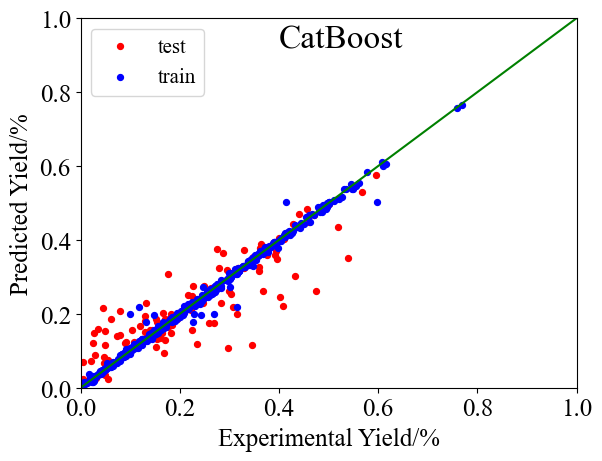

In [17]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=18,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=18,label='train')
plt.xlim((0,1))
plt.xlabel('Experimental Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=18,fontname='Times New Roman')
plt.ylim((0,1))
plt.ylabel('Predicted Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=18,fontname='Times New Roman')
plt.plot([0,1],[0,1],color='g')
plt.text(0.4,0.92,'CatBoost',fontsize=24,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=15)
plt.show()

In [18]:
feature

,Mg,Na,Pt,V,Cr,Sn,Zr,Zn,Co,Ni,...,ZrO2,SBA-1,Temperature(℃),Time(h),Number of cycles,Flow rate(C3H8),Flow rate(H2),Flow rate(CO2),Flow rate(protective gas),WHSV(Flow rate)
502,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,5.0,0.0,...,0.0,0.0,550,5.00000,3,9.09,0.0,0.0,90.91,0.98
344,0.0,0.0,0.00,2.9,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,600,0.50000,6,7.50,0.0,0.0,92.50,0.88
66,0.0,0.0,0.54,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.0,580,90.00000,1,10.00,10.0,0.0,80.00,2.20
311,0.0,0.0,0.00,5.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,580,4.00000,7,9.10,0.0,0.0,90.90,0.59
71,0.0,0.0,0.39,0.0,0.0,0.78,0.0,0.0,0.0,0.0,...,0.0,0.0,580,90.00000,1,10.00,10.0,0.0,80.00,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,20.0,0.0,...,0.0,0.0,560,0.10000,1,100.00,0.0,0.0,0.00,0.43
200,0.0,0.0,0.00,0.0,7.5,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,600,0.10000,1,20.00,0.0,0.0,80.00,2.16
34,0.0,0.0,2.00,0.0,3.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,550,8.16739,1,2.50,2.5,0.0,95.00,68.00
23,0.0,0.0,3.00,0.0,0.0,3.00,0.0,0.0,0.0,0.0,...,0.0,0.0,500,3.00000,1,20.00,0.0,0.0,80.00,47.00


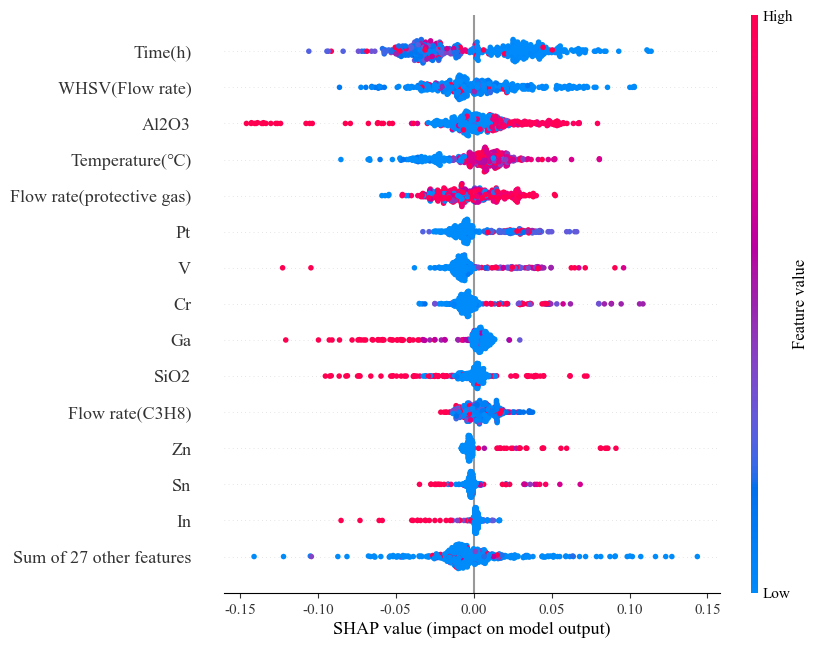

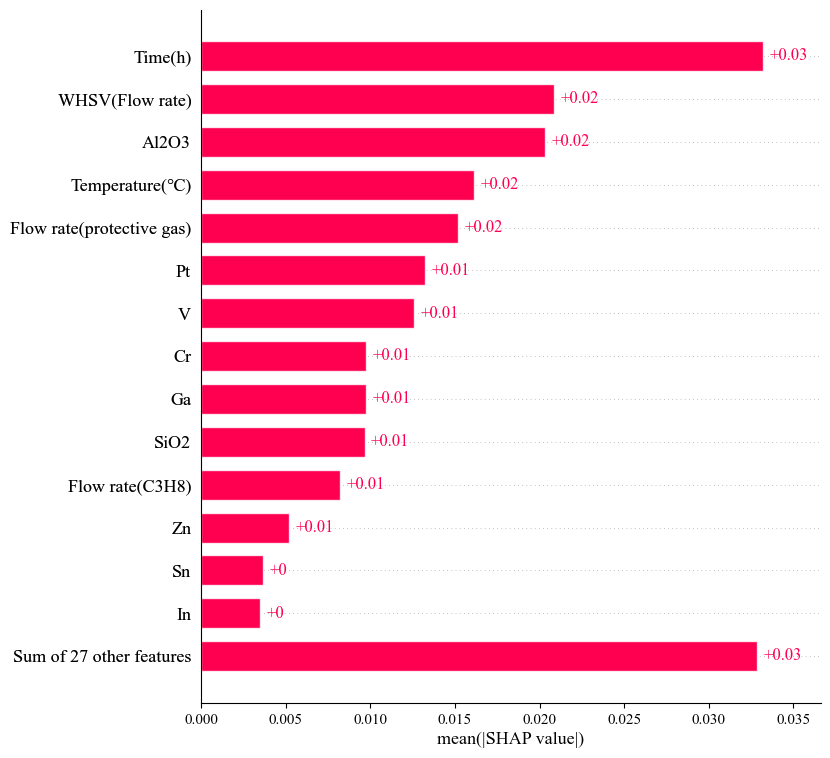

In [19]:
# shap提高解释性
# 修改字体
font = {'family': 'Times New Roman', 'size': 12}
plt.rc('font', **font)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values, max_display=15)
# visualize all the training set predictions
shap.plots.force(shap_values)

# 显示图像
plt.show()

In [10]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\Dell\anaconda3\envs\lipu\lib\site-packages\sklearn\utils\metaestimators.py)